<font size='5'>Install dependencies</font>

In [64]:
%pip install -r requirements.txt -v

Using pip 25.1 from c:\Users\Thilina Perera\miniconda3\envs\info_spam_email\Lib\site-packages\pip (python 3.11)
Note: you may need to restart the kernel to use updated packages.


<font size='5'>Import Libraries</font>

In [65]:
# Core dependencies
import pandas as pd
import numpy as np

# NLP model
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

# Text pre-processing and cleaning
import string

import imblearn
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Spacy:", spacy.__version__)
print("ImbLearn:", imblearn.__version__)
print("Scikit-learn:", sklearn.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Seaborn:", sns.__version__)
print("✅ Libraries Loaded")


Pandas: 2.3.2
NumPy: 2.3.2
Spacy: 3.8.7
ImbLearn: 0.14.0
Scikit-learn: 1.7.1
Matplotlib: 3.10.5
Seaborn: 0.13.2
✅ Libraries Loaded


<font size='5'>Load Pre-trained SpaCy model</font>

In [66]:
nlp = spacy.load("en_core_web_sm")


<font size='5'>Gather Stop Words</font>

In [67]:
stopwords = STOP_WORDS
print(stopwords)
print(len(stopwords))

{'moreover', 'towards', 'give', 'neither', 'anything', 'hundred', 'a', 'somewhere', 'one', 'n‘t', 'at', 'yet', 'after', 'become', 'eleven', 'anywhere', 'three', 'just', 'its', 'wherein', 'so', 'hereby', 'none', 'here', 'say', 'down', 'nowhere', "'s", 'over', 'nevertheless', 'myself', 'part', 'thence', 'nine', 'sometimes', 'seem', 'against', 'was', "'re", 'has', 'via', 'might', 'side', 'you', 'his', 'go', 'own', '‘d', 'get', 'both', 'hereupon', 'under', 'throughout', 'though', 'five', 'this', 'mostly', 'then', 'from', 'becoming', 'yourself', 'almost', 'whole', 'whose', 'whom', 'did', 'twelve', 'nothing', 'should', 'can', "n't", 'other', "'d", 'thereby', 'each', '‘s', 'because', 'they', 'during', 'beforehand', 'above', 'only', 'into', 'someone', 'am', 'anyhow', 'himself', 'per', 'no', 'whither', 'amongst', 'even', 'latterly', 'such', 'not', 'as', 'else', 'yours', 'thereafter', 'first', 'many', 'herself', 'often', 'rather', 'those', 'thereupon', 'very', 'becomes', 'same', 'have', 'using',

<font size='5'>Load English parser</font>

In [68]:
# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

<font size='5'>Load Dataset and Basic Info.</font>### 

In [69]:
df_spam = pd.read_csv(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\1_data\emails.csv') # data set location

print("1. Head of the table:")
print(df_spam.head())

print("\n2. Summary of data types, non-null counts, and memory usage:\n")
print(df_spam.info())

print("\n3. Dataset Shape (rows, columns):\n")
print(df_spam.shape)

print("\n4. Missing Values:\n")
print(df_spam.isnull().sum())

print("\n5. Value Counts for Spam Column:\n")
print(df_spam['spam'].value_counts())

1. Head of the table:
                                                text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1

2. Summary of data types, non-null counts, and memory usage:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB
None

3. Dataset Shape (rows, columns):

(5728, 2)

4. Missing Values:

text    0
spam    0
dtype: int64

5. Value Counts for Spam Column:

spam
0    4360
1    1368
Name: count, dtype: int64


<font size='5'>Insights</font>
<font size='3'>
* No additional cells to drop
* No null values
* Spam : Not spam dataset is unbalanced -> Need to balance 
</font>

<font size='5'>Create a subset of the dataset by upsamlpling with SMOTE</font>

In [70]:
# Basic text preprocessing and vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df_spam['text'])
y = df_spam['spam']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Convert back to DataFrame for convenience
balanced_df = pd.DataFrame.sparse.from_spmatrix(X_balanced, columns=vectorizer.get_feature_names_out())
balanced_df['spam'] = y_balanced

print("Balanced Dataset Shape:", balanced_df.shape)
print("Value Counts for Spam Column:\n", balanced_df['spam'].value_counts())

Balanced Dataset Shape: (8720, 5000)
Value Counts for Spam Column:
 spam
1    4360
0    4360
Name: count, dtype: int64


In [71]:
# Punctuation characters
punctuation = string.punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


<font size='5'>Remove Stop Words and Punctuation Marks</font>

In [72]:
def clean_data(sentence):
  doc = nlp(sentence)
  tokens = []
  for token in doc:
    if token.lemma_ != '-PRON-':
      temp = token.lemma_.lower().strip()
    else:
      temp = token.lower_
    tokens.append(temp)
  clean_tokens = []
  for token in tokens:
    if token not in punctuation and token not in stopwords:
      clean_tokens.append(token)
  return clean_tokens

<font size='5'>Applying Train-Test Splitting to Dataset</font>

In [73]:
x = balanced_df['text']
y = balanced_df['spam']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (6976,)
x_test shape: (1744,)
y_train shape: (6976,)
y_test shape: (1744,)


<font size='5'>Creating the Model and Pipeline</font>

In [74]:
tfidf = TfidfVectorizer(tokenizer = clean_data)
lgr = LogisticRegression()
steps = [('tfidf',tfidf),('lgr',lgr)]
pipe = Pipeline(steps)

<font size='5'>Model Training</font>

In [75]:
x_train = x_train.astype(str)
pipe.fit(x_train, y_train)
pipe.fit(x_train,y_train)

c:\Users\Thilina Perera\miniconda3\envs\info_spam_email\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Thilina Perera\miniconda3\envs\info_spam_email\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,steps,"[('tfidf', ...), ('lgr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function cle...00153C1739940>


<font size='5'>Save the model</font>

In [76]:
from joblib import dump
dump(pipe, r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\3_models\spam_email_classifier_model_smote.h5')

print("D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\3_models\spam_email_classifier_model_smote.h5'")

D:\Z1. Data Science Career. Python\Infotech5.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech_models\spam_email_classifier_model_smote.h5'


<font size='5'>Make Predictions</font>

In [ ]:
x_test = x_test.astype(str)
y_pred = pipe.predict(x_test)

<font size='5'>Classification report and the confusion matrix</font>

In [ ]:
print(classification_report(y_test, y_pred))
print("\n\n")
print(confusion_matrix(y_test, y_pred))

# Save results
with open(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\1_test_data\classification_report_smote.txt', 'w') as f:
    f.write(classification_report(y_test, y_pred))
np.savetxt(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\1_test_data\confusion_matrix_smote.txt', confusion_matrix(y_test, y_pred), fmt='%d')

              precision    recall  f1-score   support

           0       0.50      0.98      0.67       859
           1       0.79      0.05      0.10       885

    accuracy                           0.51      1744
   macro avg       0.64      0.52      0.38      1744
weighted avg       0.65      0.51      0.38      1744




[[846  13]
 [837  48]]


<font size='5'>Model Accuracy</font>

In [86]:
t_accuracy = metrics.accuracy_score(y_test, y_pred)
t_precision = metrics.precision_score(y_test, y_pred)
t_recall = metrics.recall_score(y_test, y_pred)
t_f1 = metrics.f1_score(y_test, y_pred)

print("Test Metrics:")
print(f"Accuracy: {t_accuracy}")
print(f"Precision: {t_precision}")
print(f"Recall: {t_recall}")
print(f"F1-Score: {t_f1}")

# Save metrics
with open(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\1_test_data\metrics_smote_test.txt', 'w') as f:
    f.write(f"Accuracy: {t_accuracy}\n")
    f.write(f"Precision: {t_precision}\n")
    f.write(f"Recall: {t_recall}\n")
    f.write(f"F1-Score: {t_f1}\n")

Test Metrics:
Accuracy: 0.5126146788990825
Precision: 0.7868852459016393
Recall: 0.05423728813559322
F1-Score: 0.1014799154334038


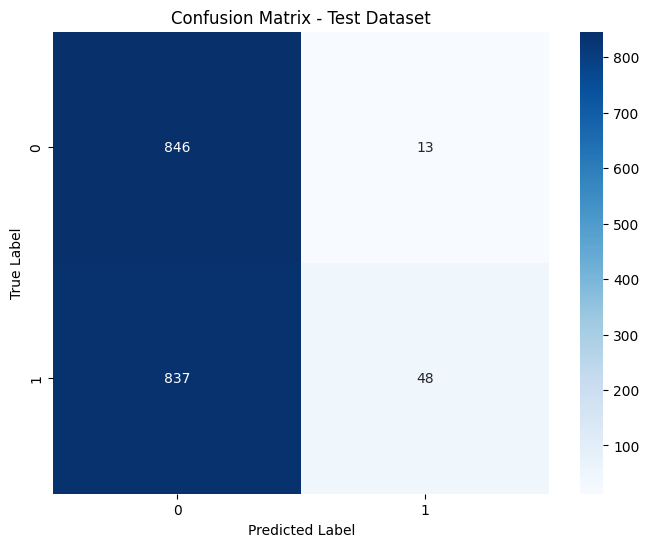

In [79]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\1_test_data\confusion_matrix_smote_test.png')
plt.show()
plt.close()

<font size='6'>Model Validation using External Dataset</font>

<font size='5'>Load & Pre-process Dataset</font>

In [80]:
val_df = pd.read_csv(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\1_data\validation_dataset.csv')
val_text = val_df['text']
val_labels = val_df['spam']

<font size='5'>Preprocess text using the same clean_data function</font>

In [81]:
val_processed = [clean_data(text) for text in val_text]

<font size='5'>Convert processed text back to strings for prediction</font>

In [82]:
val_processed_str = [' '.join(tokens) for tokens in val_processed]

<font size='5'>Make predictions</font>

In [83]:
val_pred = pipe.predict(val_processed_str)

<font size='5'>Model validating</font>

In [84]:
# Classification report and the confusion matrix
print("Classification Report:\n", classification_report(val_labels, val_pred))
print("\n")
print("Confusion Matrix:\n", confusion_matrix(val_labels, val_pred))

# Save results
with open(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\2_validation_data\classification_report_smote_val.txt', 'w') as f:
    f.write(classification_report(val_labels, val_pred))
np.savetxt(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\2_validation_data\confusion_matrix_smote_val.txt', confusion_matrix(val_labels, val_pred), fmt='%d')

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.50      1.00      0.67         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10



Confusion Matrix:
 [[0 5]
 [0 5]]


c:\Users\Thilina Perera\miniconda3\envs\info_spam_email\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Thilina Perera\miniconda3\envs\info_spam_email\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Thilina Perera\miniconda3\envs\info_spam_email\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

<font size='5'>Model Accuracy</font>

In [87]:
v_accuracy = metrics.accuracy_score(val_labels, val_pred)
v_precision = metrics.precision_score(val_labels, val_pred)
v_recall = metrics.recall_score(val_labels, val_pred)
v_f1 = metrics.f1_score(val_labels, val_pred)

print("Test Metrics:")
print(f"Accuracy: {v_accuracy}")
print(f"Precision: {v_precision}")
print(f"Recall: {v_recall}")
print(f"F1-Score: {v_f1}")

# Save metrics
with open(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\2_validation_data\metrics_smote_val.txt', 'w') as f:
    f.write(f"Accuracy: {v_accuracy}\n")
    f.write(f"Precision: {v_precision}\n")
    f.write(f"Recall: {v_recall}\n")
    f.write(f"F1-Score: {v_f1}\n")

Test Metrics:
Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1-Score: 0.6666666666666666


<font size='5'>Visualize confusion matrix</font>

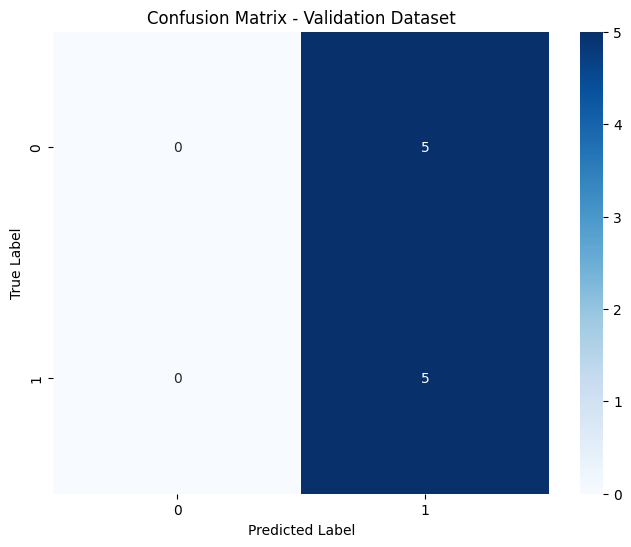

In [85]:
cm = confusion_matrix(val_labels, val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\2_validation_data\confusion_matrix_smote_val.png')
plt.show()
plt.close()